In [26]:
# Follow this tutorial
# https://qucontrol.github.io/krotov/v1.2.1/notebooks/07_example_PE.html#Optimization

In [27]:
#  1. we aren't considering virtual z-gates, we could use state-to-state functional but was getting errors
#  2. simulated annealing learning rate?
#  3. not every 1Q variance has a solution, find subset that do, particular for CX and SWAP decomp targets
#  4. we see that when the solution is 1Q gates are off, the optimizer still struggles to find that solution with high fidelity
#  5. getting errors when turning on local variance in objective function
#  6. !!!! we think cnot with phase =0 doesn't change its coordinate - maybe it works with smushing?

In [28]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

%matplotlib widget

import sys
sys.path.append("../../../")
import numpy as np

In [29]:
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
from IPython.display import display
import weylchamber as wc
from weylchamber.visualize import WeylChamber
from weylchamber.coordinates import from_magic

In [30]:
gc, gg = (np.pi/2, 0*np.pi/4)
T = 1.0  # final time
nt = 100
u0 = 2*np.pi
tlist = np.linspace(0, T, nt)

In [31]:
def eps0(t, args):
    return u0*krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=(T / 20), t_fall=(T / 20), func='sinsq'
    )

def eps1(t, args):
    return u0*krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=(T / 20), t_fall=(T / 20), func='sinsq'
    )

In [32]:
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    plt.show(fig)

In [33]:
def hamiltonian(phi_c, phi_g, gc, gg, gx0, gy0):
    """Two qubit Hamiltonian"""

    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2)
    B = qutip.tensor(I2, a)


    #     # local qubit Hamiltonians
    # Hq1 = 0.5 * w1 * np.diag([-1, 1])
    # Hq2 = 0.5 * w2 * np.diag([-1, 1])

    # # lift Hamiltonians to joint system operators
    # H0 = np.kron(Hq1, np.identity(2)) + np.kron(np.identity(2), Hq2)



    # construct Hamiltonian
    Ha = (A + A.dag())
    Hb = (B + B.dag())
    H_c = np.exp(1j * phi_c) * A * B.dag() + np.exp(-1j * phi_c) * A.dag() * B
    H_g = np.exp(1j * phi_g) * A * B + np.exp(-1j * phi_g) * A.dag() * B.dag()
    H1 = gc * H_c + gg * H_g

    # convert Hamiltonians to QuTiP objects
    # H0 = qutip.Qobj(H0)
    H1 = qutip.Qobj(H1)
    Ha = qutip.Qobj(Ha)
    Hb = qutip.Qobj(Hb)
    # H1 = qutip.Qobj(H1)
    # H2 = qutip.Qobj(H2)


    # return [H0, [H1, eps0]]

    #reshaping from [[2],[2]] to [4,4]
    H1 = qutip.Qobj(H1.data,dims=[[4],[4]])
    Ha = qutip.Qobj(Ha.data,dims=[[4],[4]])   
    Hb = qutip.Qobj(Hb.data,dims=[[4],[4]])   

    return [H1, [Ha, eps0], [Hb, eps1]] #renamed to eps1 to avoid dictionary key clash


H = hamiltonian(phi_c=0, phi_g=0, gc=gc, gg=gg, gx0=0, gy0=0)
# H = qutip.Qobj(H[0].data,dims=[[4],[4]])


In [34]:
# def hamiltonian(w1=w1, w2=w2, J=J, la=la, u0=u0):
#     """Two qubit Hamiltonian

#     Args:
#         w1 (float): energy separation of the first qubit levels
#         w2 (float): energy separation of the second qubit levels
#         J (float): effective coupling between both qubits
#         la (float): factor that pulse coupling strength differs for second qubit
#         u0 (float): constant amplitude of the driving field
#     """
#     # local qubit Hamiltonians
#     Hq1 = 0.5 * w1 * np.diag([-1, 1])
#     Hq2 = 0.5 * w2 * np.diag([-1, 1])

#     # lift Hamiltonians to joint system operators
#     H0 = np.kron(Hq1, np.identity(2)) + np.kron(np.identity(2), Hq2)

#     # define the interaction Hamiltonian
#     sig_x = np.array([[0, 1], [1, 0]])
#     sig_y = np.array([[0, -1j], [1j, 0]])
#     Hint = 2 * J * (np.kron(sig_x, sig_x) + np.kron(sig_y, sig_y))
#     H0 = H0 + Hint

#     # define the drive Hamiltonian
#     H1 = np.kron(np.array([[0, 1], [1, 0]]), np.identity(2)) + la * np.kron(
#         np.identity(2), np.array([[0, 1], [1, 0]])
#     )

#     # convert Hamiltonians to QuTiP objects
#     H0 = qutip.Qobj(H0)
#     H1 = qutip.Qobj(H1)

#     return [H0, [H1, eps0]]


# H = hamiltonian(w1=w1, w2=w2, J=J, la=la, u0=u0)

In [35]:
psi_00 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([1, 0])))
psi_01 = qutip.Qobj(np.kron(np.array([1, 0]), np.array([0, 1])))
psi_10 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([1, 0])))
psi_11 = qutip.Qobj(np.kron(np.array([0, 1]), np.array([0, 1])))
basis_states = [psi_00, psi_01, psi_10, psi_11]

In [36]:
proj_00 = qutip.ket2dm(psi_00)
proj_01 = qutip.ket2dm(psi_01)
proj_10 = qutip.ket2dm(psi_10)
proj_11 = qutip.ket2dm(psi_11)

In [37]:
from qiskit import QuantumCircuit
from src.utils.custom_gates import ConversionGainGate, CanonicalGate, BerkeleyGate
from qiskit.quantum_info import Operator, random_unitary
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import SwapGate, CPhaseGate

# from src.sampler import GateSample  
# qc = QuantumCircuit(2)
# # qc.append(random_unitary(2), [0])
# # qc.append(random_unitary(2), [1])
# g = ConversionGainGate(0, 0, gc, gg, t_el=1.0)
# qc.append(g, [0,1])
# qc.append(random_unitary(2), [0])
# qc.append(random_unitary(2), [1])
# # qc.rx(-np.pi/2, 0)
# # qc.rx(-np.pi/2, 1)
# qc.draw('mpl');
# gate_data = Operator(qc).data

# qc = QuantumCircuit(2)
# qc.append(BerkeleyGate(), [0,1])
# qc.append(random_unitary(2), [0])
# qc.append(random_unitary(2), [1])
# gate_data = Operator(qc).data

gate_data = CanonicalGate(np.pi / 4, np.pi / 8, np.pi/8).to_matrix()
gate_data = CanonicalGate(6*np.pi/8, 0, 0).to_matrix()
gate_data = CPhaseGate(theta= 1.5* np.pi).inverse().to_matrix()

# from smush_sqiswap.ipynb
gate_data = np.array([[-9.46073893e-01-3.23950901e-01j,  7.52727300e-06+1.48322966e-05j,
         2.94187599e-05+7.74408998e-06j,  4.19924316e-05-1.55821066e-05j],
       [-2.36262549e-05-3.80524888e-05j, -1.76803539e-05-8.38430158e-06j,
         9.31614726e-06-1.53352949e-05j, -9.46063756e-01-3.23980505e-01j],
       [-2.79905333e-05-1.19149014e-05j, -4.85744092e-05-3.82839177e-07j,
        -9.46062499e-01-3.23984174e-01j,  2.04261036e-06-1.78273925e-05j],
       [-1.50375118e-05+7.10662866e-06j, -9.46068103e-01-3.23967809e-01j,
         3.86126018e-05+2.94739471e-05j,  1.91084645e-05+4.21392507e-06j]])
         
# gate_data = SwapGate().to_matrix()
# sampler = GateSample(UnitaryGate(gate_data))

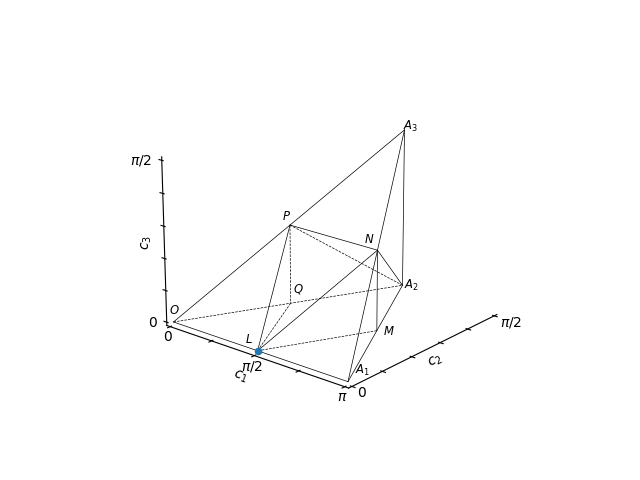

In [38]:
from src.utils.visualize import unitary_to_weyl, c1c2c3
c1c2c3(gate_data)
unitary_to_weyl(gate_data);

In [39]:
objectives = krotov.gate_objectives(
    basis_states=basis_states, gate=gate_data, H=H, local_invariants=0) #XXX local_invariants flag just doesnt work!

In [40]:
class sigma(krotov.second_order.Sigma):
    def __init__(self, A, epsA=0):
        self.A = A
        self.epsA = epsA

    def __call__(self, t):
        ϵ, A = self.epsA, self.A
        return -max(ϵ, 2 * A + ϵ)

    def refresh(
        self,
        forward_states,
        forward_states0,
        chi_states,
        chi_norms,
        optimized_pulses,
        guess_pulses,
        objectives,
        result,
    ):
        try:
            Delta_J_T = result.info_vals[-1][0] - result.info_vals[-2][0]
        except IndexError:  # first iteration
            Delta_J_T = 0
        self.A = krotov.second_order.numerical_estimate_A(
            forward_states, forward_states0, chi_states, chi_norms, Delta_J_T
        )

In [41]:
def S(t):
    """Shape function for the field update"""
    return krotov.shapes.flattop(
        t, t_start=0, t_stop=T, t_rise=T / 20, t_fall=T / 20, func='sinsq'
    )

In [42]:
# def check_PE(result):
#     # extract F_PE from (F_PE, [c1, c2, c3])
#     F_PE = result.info_vals[-1][0]
#     if F_PE <= 0:
#         return "achieved perfect entangler"
#     else:
#         return None 

In [43]:
from krotov.functionals import chis_hs, J_T_hs, J_T_wc
# from krotov.functionals import chis_ss, J_T_ss
# from krotov.functionals import chis_re, J_T_re
from weylchamber import make_LI_krotov_chi_constructor, J_T_LI
from krotov.convergence import check_monotonic_error, value_below, Or
from krotov.info_hooks import print_table, chain

In [44]:
# learning_rate = .01 # (reversed rules) bigger is smaller learning rate
# pulse_options = {H[1][1]: dict(lambda_a=learning_rate, update_shape=S), H[2][1]: dict(lambda_a=learning_rate, update_shape=S)}

In [45]:
from weylchamber import make_PE_krotov_chi_constructor, make_PE_krotov_chi_constructor

In [46]:
class simulated_annealer():
    def __init__(self):
        self.prev_optimized = None
        self.opt_result = None
        self.save_optimized = None
        self.coordinate_list = []
        self.iters = 0

    def train(self):
        for i, learning_rate in enumerate([.1, .25, .5, .75, 1, 2, 3]): # (reversed rules) bigger is smaller learning rate
            print("learning rate: ", learning_rate)
            pulse_options = {H[1][1]: dict(lambda_a=learning_rate, update_shape=S), H[2][1]: dict(lambda_a=learning_rate, update_shape=S)}
            self.opt_result = krotov.optimize_pulses(
                objectives,
                pulse_options=pulse_options,
                tlist=tlist,
                propagator=krotov.propagators.expm,
                # chi_constructor=make_PE_krotov_chi_constructor(basis_states),
                chi_constructor = chis_hs,
                # info_hook=chain(self.save_coordinate, print_table(J_T=J_T_wc), self.save_iteration),
                info_hook=chain(self.save_coordinate, print_table(J_T=J_T_hs), self.save_iteration),
                # info_hook=chain(self.save_coordinate, self.save_iteration),
                # check_convergence=value_below(1e-10, name='J_T'),
                check_convergence=Or(value_below(1e-10, name='J_T'), check_monotonic_error),
                iter_stop=40*i,
                continue_from=self.opt_result,
                sigma=sigma(A=0.0),
                # modify_params_after_iter = {'lambda_a': 1} not sure how to use this exactly
                # norm= lambda state: np.linalg.norm(state)
                # skip_initial_forward_propagation=True,
            )
            #truncate opt_result, if convergence was reached because broke monotonicity
            if "Loss of monotonic convergence" in self.opt_result.message:
                # remove the faulty iteration
                print("removing faulty iteration")
                # self.delete_iteration()
    
    def save_coordinate(self, **args):
        basis = [objectives[i].initial_state for i in [0, 1, 2, 3]]
        states = [args['fw_states_T'][i] for i in [0, 1, 2, 3]]
        U = wc.gates.gate(basis, states)
        O = gate_data
        c1, c2, c3 = wc.coordinates.c1c2c3(U)
        # print(f'c1: {c1}, c2: {c2}, c3: {c3}')
        self.coordinate_list.append([c1, c2, c3])
        dist = J_T_LI(O, U)
        # print iters and dist
        print(f'iters: {self.iters}, dist: {dist}')
        # return dist

    def delete_iteration(self):
        self.opt_result.iters[-1] = self.opt_result.iters[-2]
        self.opt_result.iter_seconds[-1] = self.opt_result.iter_seconds[-2]
        self.opt_result.info_vals[-1] = self.opt_result.info_vals[-2]
        self.opt_result.tau_vals[-1] = self.opt_result.tau_vals[-2]
        if self.prev_optimized is None:
            raise ValueError("No previous optimized pulses to revert to")
        self.opt_result.optimized_controls = self.prev_optimized
        pass

    def save_iteration(self, **args):
        # deepcopy to avoid overwriting
        import copy
        if self.save_optimized is not None:
            self.prev_optimized = self.save_optimized
        self.save_optimized = copy.deepcopy(args['optimized_pulses'])
        self.iters += 1

In [47]:
sa = simulated_annealer()
sa.train()
opt_result = sa.opt_result
print(opt_result)

learning rate:  1
iters: 0, dist: 4.00869451832173
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.46e-01    0.00e+00   9.46e-01        n/a        n/a     3
learning rate:  2
iters: 1, dist: 4.00869451832173
iter.      J_T   ∑∫gₐ(t)dt          J       ΔJ_T         ΔJ  secs
0     9.46e-01    0.00e+00   9.46e-01        n/a        n/a     3
iters: 2, dist: 4.00412366720253
1     9.35e-01    6.28e-03   9.41e-01  -1.13e-02  -5.02e-03     8
iters: 3, dist: 3.9972364643184304
2     9.30e-01    1.39e-03   9.31e-01  -4.96e-03  -3.57e-03     9
iters: 4, dist: 3.9920854449939425
3     9.27e-01    5.84e-04   9.28e-01  -2.80e-03  -2.21e-03     9
iters: 5, dist: 3.9884554198493687
4     9.25e-01    3.11e-04   9.26e-01  -1.78e-03  -1.47e-03    10
iters: 6, dist: 3.985851987838935
5     9.24e-01    1.88e-04   9.24e-01  -1.22e-03  -1.03e-03     9
iters: 7, dist: 3.9839388062531182
6     9.23e-01    1.24e-04   9.23e-01  -8.76e-04  -7.52e-04    10
iters: 8, dist: 3.9825048327099

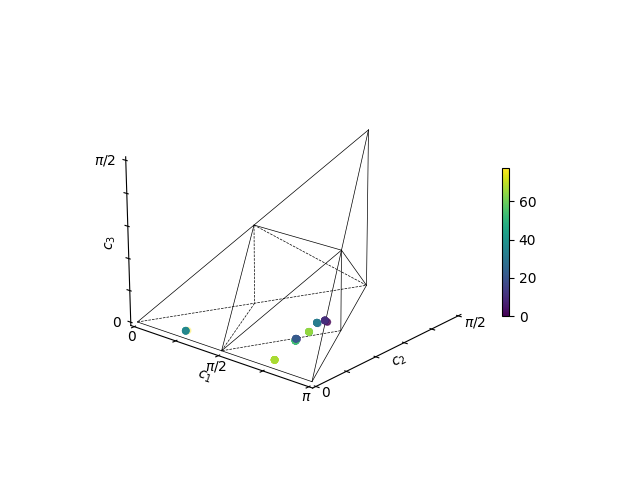

In [ ]:
# w = WeylChamber()
# c1c2c3 = [sa.coordinate_list[i] for i in range(len(opt_result.iters))]
# for i in range(len(opt_result.iters)):
#     w.add_point(c1c2c3[i][0], c1c2c3[i][1], c1c2c3[i][2])
# w.plot()

from src.utils.visualize import coordinate_2dlist_weyl
coordinate_2dlist_weyl(sa.coordinate_list, c=range(len(sa.coordinate_list)));

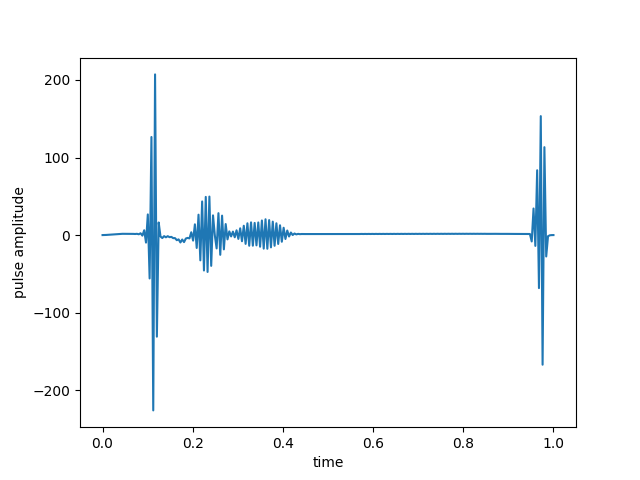

In [ ]:
plot_pulse(opt_result.optimized_controls[1], tlist)